# <font color='darkblue'>Análise dos Indicadores a Nível Municipal    </font>

### Carregando os pacotes

In [1]:
if('pacman'%in%rownames(installed.packages())){
  library(pacman)
}else{
  install.packages('pacman')
  library(pacman)
}


Warning message:
"package 'pacman' was built under R version 3.6.3"

In [2]:
p_load(
readxl,
dplyr,
ggplot2,
stringr,
curl,
sf,
cowplot,
DT,
RCurl,
repmis,
rgdal,
utils)


### Carregamento dos dados

In [3]:
## Estamos carregando os dado direto de uma página do github 
source_data('https://github.com/giapsunb/semana_extensao_est/blob/main/dados%20muncipio/Dados_Mun.rdata?raw=true')


SHA-1 hash of the downloaded data file is:
80b9bf9031755ffa4b9af923b7b0de8ff3614772


[1] "Dados_Mun"

[1] "C:/Users/Mateus/Documents/Untitled Folder"

In [54]:
url2 <- 'https://github.com/giapsunb/semana_extensao_est/blob/main/malha/Malha_territorial/Malha_territorial.zip?raw=true'

download.file(url = url2, mode='wb',destfile = "malha.zip")

#zipF<-file.choose()

unzip('malha.zip')

library(sf)
states_completo <- st_read('malha_municipio.shp')


file.remove('malha.zip')
file.remove('malha_municipio.shp')
file.remove('malha_municipio.prj')
file.remove('malha_municipio.dbf')
file.remove('malha_municipio.shx')

Reading layer `malha_municipio' from data source `C:\Users\Mateus\Documents\Untitled Folder\malha_municipio.shp' using driver `ESRI Shapefile'
Simple feature collection with 5572 features and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -73.99045 ymin: -33.75108 xmax: -28.84784 ymax: 5.271841
Geodetic CRS:  SIRGAS 2000


[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

### Definições importantes

In [6]:
INDICADORES <- c("1:GEPRE","2:GEDST","3:GEODO","4:CITO","5:POLI","6:HIPER", "7:DIA")
Anos  <- c('2018','2019','2020')
Quadrimestres <- c("Q1","Q2","Q3")
Regioes <- c('Norte','Nordeste','Sudeste','Sul','Centro-Oeste')

In [7]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

In [8]:
levels(Dados_Mun$indicador)  <- c("1:GEPRE","2:GEDST","3:GEODO","4:CITO","5:POLI","6:HIPER", "7:DIA")

In [9]:
theme_set(theme_light() +
            theme(axis.title = element_text(size = 12),
                  axis.text = element_text(size = 10),
                  plot.title = element_text(hjust = .5),
                  axis.line = element_line(colour = "black"),
                  legend.position = "bottom",
                  panel.border = element_blank(),
                  legend.key.width = unit(1, "cm")))

### Funções necessárias para interação com usuário

In [10]:
pedir_unico_indicador <- function(){
  num2 <- readline(paste0("Digite em valor númerico de acordo com a lista acima o indicador de interesse: "))
  num2 <- str_remove_all(num2, pattern = ' ')
  num2 <- as.numeric(num2)
  while(T){
    if(between(num2,1,7)==F){
      print("Por favor digite número apenas com valores de 1 a 7, rode novamente a célula")
      break
    }
    if (!is.na(num2)) {
      indicador <- num2
      return(indicador)
      break
    }
  }  
 
}

pedir_ano <- function(){
  num <- readline(paste0("Digite em valor númerico de acordo com a lista acima para o ano inicial de interesse: "))
  num2 <- readline(paste0("Digite em valor númerico de acordo com a lista acima para o ano final de interesse: "))
  
  num <- str_remove_all(num, pattern = ' ')
  num <- as.numeric(num)
  
  num2 <- str_remove_all(num2, pattern = ' ')
  num2 <- as.numeric(num2)
  
  while(T){
    if(between(num2,2018,2020)==F | between(num,2018,2020)==F){
      print("Por favor digite número apenas com valores de 2018 a 2020, rode novamente a célula")
      break
    }
    if (!is.na(num2) & !is.na(num) ) {
      anos <- list()
      anos[[1]] <- num
      anos[[2]] <- num2
      return(anos)
      break
    }
  }  

}

pedir_quadrimestre <- function(){
  num <- readline(paste0("Digite em valor númerico de acordo com a lista acima para o quadrimestre inicial de interesse: "))
  num2 <- readline(paste0("Digite em valor númerico de acordo com a lista acima para o quadrimestre final de interesse: "))
  
  num <- str_remove_all(num, pattern = ' ')
  num <- as.numeric(num)
  
  num2 <- str_remove_all(num2, pattern = ' ')
  num2 <- as.numeric(num2)
  
  while(T){
    if(between(num,1,3)==F | between(num2,1,3)==F){
      print("Por favor digite número apenas com valores de 1 a 3, rode novamente a célula")
      break
    }
    if (!is.na(num2) & !is.na(num) ) {
      anos <- list()
      anos[[1]] <- num
      anos[[2]] <- num2
      return(anos)
      break
    }
  }  
  
}



pedir_indicadores <- function(){
  while(T) {
    num <- readline("Indique numericamente quantos indicadores deseja selecionar: ")
    num <- str_remove_all(num, pattern =' ')
    num <- as.numeric(num)
    
    if(between(num,1,3)==F){
      print("Por favor digite número apenas com valores de 1 a 3, rode novamente a célula")
        break
    }
    if (!is.na(num)) {
      num2 <- readline(paste0("Digite ",num, " em valores númericos de acordo com a lista acima os indicadores de interesse e separado por vígula: "))
      indicadores <- as.numeric(unlist(str_split(num2, pattern=",")))
      break
    }
  }

  return(indicadores)
}



pedir_cod_mun <- function(){
  num2 <- readline(paste0("Digite em valor númerico o código do IBGE do munícipio de interesse: "))
  num2 <- str_remove_all(num2, pattern = ' ')
  num <- as.numeric(num2)
  
  while(T){
    if(str_length(num2)!=6){
      print("Por favor digite um código de município válido. O código é de 6 digitos. Rode a célula novamente.")
      break
    }
     
      if(num %in% unique(Dados_Mun$ibge)){
        indicador <- num
        return(indicador)
        break
      }else{
        print("Por favor digite um código de município válido. O código é de 6 digitos. Rode a célula novamente.")
        break
      }
    
      
    }

}

# SELEÇÃO DE INFORMAÇÕES PARA AS ANÁLISES

### Procure na caixa de pesquisa o código IBGE do município de interesse utilizando o nome


In [11]:
datatable(unique(Dados_Mun[,c('ibge','uf' ,'nome_mun')]),colnames=c('Código IBGE','UF','Município'), options = list(lengthMenu = c(5, 10,15), pageLength = 5, names))

HTML widgets cannot be represented in plain text (need html)

### Digite o código IBGE do município de interesse

In [26]:
municipio_selecionado = pedir_cod_mun()

Digite em valor númerico o código do IBGE do munícipio de interesse: 317020


### Selecione o número relacionado ao Indicador de Interesse

1. [proporção de gestantes com pelo menos 6 (seis) consultas pré-natal realizadas, sendo a 1ª até a 20ª semana de gestação (GEPRE);](https://drive.google.com/file/d/1EUnzI4QD7RGkCNCFN0vHayjM5GzvINrw/view?usp=sharing)
2. [proporção de gestantes com realização de exames para sífilis e HIV (GEDST );](https://drive.google.com/file/d/1YCz5n7Ru0Y6Tf-MwN4cRik4za2xX9U6g/view?usp=sharing)
3. [proporção de gestantes que passaram por atendimento odontológico (GEODO);](https://drive.google.com/file/d/1gABZ34w2oA57lJ4AB7dNW1ou_Bz5VEIZ/view?usp=sharing)
4. [cobertura de exame citopatológico (CITO);](https://drive.google.com/file/d/1IGGXKfkJEFjR30440NU2ArcN4zHcd2ep/view?usp=sharing)
5. [cobertura vacinal de poliomielite inativada e de pentavalente (POLI);](https://drive.google.com/file/d/1RukreNZvzZeN0OzuK2gzhDprgIPmjjZB/view?usp=sharing)
6. [percentual de pessoas hipertensas com pressão arterial aferida em cada semestre (HIPER);](https://drive.google.com/file/d/1NQDNzFAp8iMzgpEHZc9oZq6dFNru1gha/view?usp=sharing) 
7. [percentual de diabéticos com solicitação de hemoglobina glicada (DIA).](https://drive.google.com/file/d/1xe5LRXgYRsBuhfWbYbzZoYy0BJGtM4kK/view?usp=sharing)

In [13]:
indicadores <- pedir_indicadores()

Indique numericamente quantos indicadores deseja selecionar: 3
Digite 3 em valores númericos de acordo com a lista acima os indicadores de interesse e separado por vígula: 1,2,3


### Selecionar Indicador de Interesse

1. [proporção de gestantes com pelo menos 6 (seis) consultas pré-natal realizadas, sendo a 1ª até a 20ª semana de gestação (GEPRE);](https://drive.google.com/file/d/1EUnzI4QD7RGkCNCFN0vHayjM5GzvINrw/view?usp=sharing)
2. [proporção de gestantes com realização de exames para sífilis e HIV (GEDST );](https://drive.google.com/file/d/1YCz5n7Ru0Y6Tf-MwN4cRik4za2xX9U6g/view?usp=sharing)
3. [proporção de gestantes que passaram por atendimento odontológico (GEODO);](https://drive.google.com/file/d/1gABZ34w2oA57lJ4AB7dNW1ou_Bz5VEIZ/view?usp=sharing)
4. [cobertura de exame citopatológico (CITO);](https://drive.google.com/file/d/1IGGXKfkJEFjR30440NU2ArcN4zHcd2ep/view?usp=sharing)
5. [cobertura vacinal de poliomielite inativada e de pentavalente (POLI);](https://drive.google.com/file/d/1RukreNZvzZeN0OzuK2gzhDprgIPmjjZB/view?usp=sharing)
6. [percentual de pessoas hipertensas com pressão arterial aferida em cada semestre (HIPER);](https://drive.google.com/file/d/1NQDNzFAp8iMzgpEHZc9oZq6dFNru1gha/view?usp=sharing) 
7. [percentual de diabéticos com solicitação de hemoglobina glicada (DIA).](https://drive.google.com/file/d/1xe5LRXgYRsBuhfWbYbzZoYy0BJGtM4kK/view?usp=sharing)

In [14]:
INDICADOR <-  pedir_unico_indicador()

Digite em valor númerico de acordo com a lista acima o indicador de interesse: 2


### Digite o Ano Inicial e um Ano Final no formato yyyy

- 2018
- 2019
- 2020

In [15]:
ANOS <- pedir_ano()
ANO_INICIAL <- ANOS[[1]]
ANO_FINAL <- ANOS[[2]]

Digite em valor númerico de acordo com a lista acima para o ano inicial de interesse: 2018
Digite em valor númerico de acordo com a lista acima para o ano final de interesse: 2018


### Digite o número relacionado ao Quadrimeste Inicial e um Quadrimestre Final

1. Primeiro Quadrimestre
2. Segundo Quadrimestre
3. Terceiro Quadrimestre

In [16]:
QUADRIMESTRES <- pedir_quadrimestre()
Quadrimestre_Inicial <- QUADRIMESTRES[[1]]
Quadrimestre_Final <- QUADRIMESTRES[[2]]

Digite em valor númerico de acordo com a lista acima para o quadrimestre inicial de interesse: 1
Digite em valor númerico de acordo com a lista acima para o quadrimestre final de interesse: 2


#  ANÁLISES UTILIZANDO AS INFORMAÇÕES SELECIONADAS

## Série Temporal do Município para Indicadores Selecionados

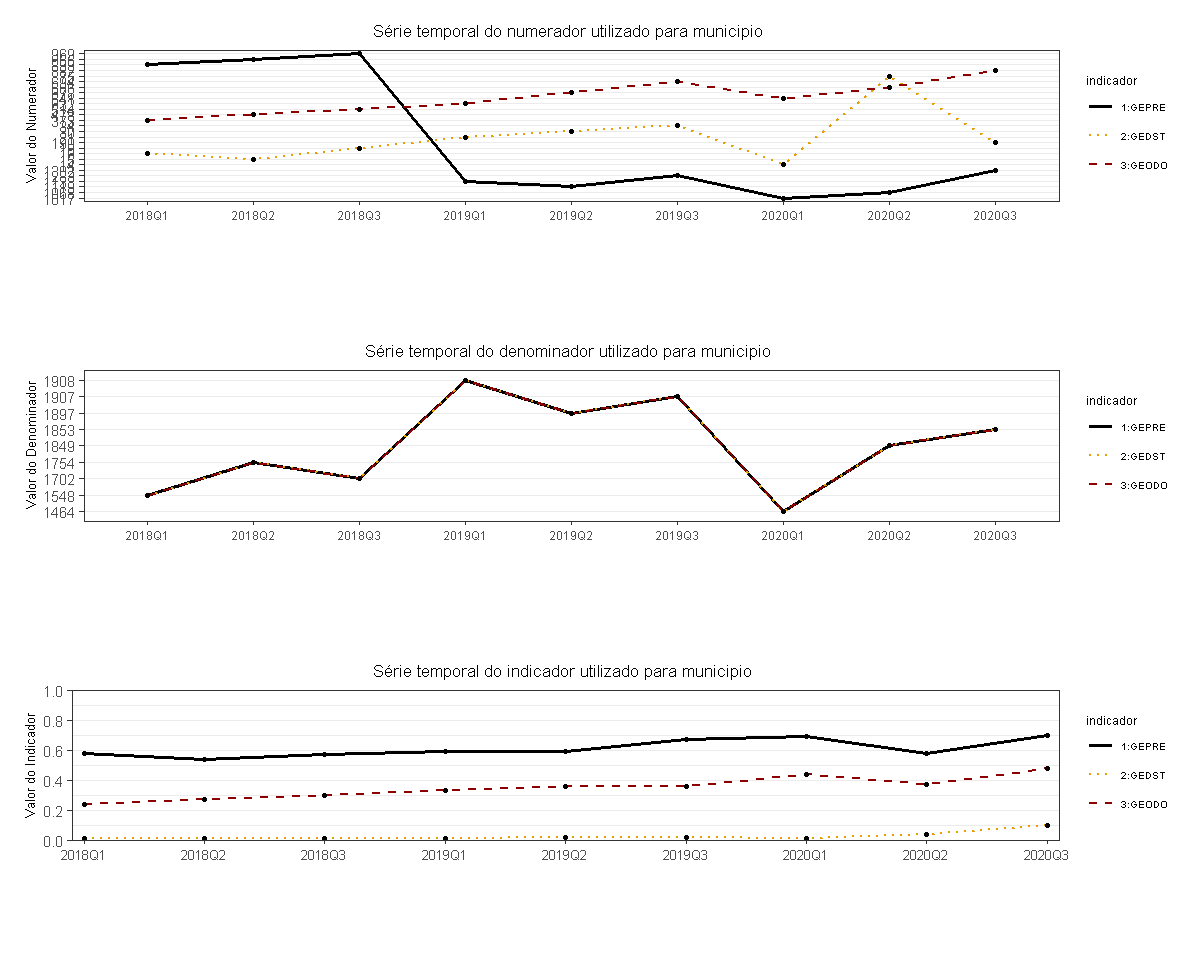

In [43]:
Teste <- Dados_Mun %>% filter(indicador%in%c(INDICADORES[indicadores]), ibge ==municipio_selecionado)
nome_mun_selecionado <- unique(Teste$Nome_Mun)


G1 <- Teste %>% 
  ggplot(aes(x=tempo, y=indicador_calculado, group=indicador)) +
  geom_line(aes(linetype=indicador, color=indicador, size=indicador))+
  geom_point(size=1)+
  scale_linetype_manual(values=c("solid", "dotted",'dashed'))+
  scale_color_manual(values=c('black','#E69F00','darkred'))+
  scale_size_manual(values=c(0.9, 0.8,0.6))+
  coord_cartesian(ylim = c(0, 1), expand = FALSE, clip = "off",xlim=c(0.9,9.1)) +
  scale_y_continuous(breaks = seq(0,1.0,.20))+
  ggtitle(paste0("Série temporal do indicador utilizado para municipio ",nome_mun_selecionado))+
  theme_bw() +
  labs(y="Valor do Indicador", x='Ano e Quadrimestre')+
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
        axis.title.y = element_text(size=8),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=0, size=8),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_text(size=7),
        legend.text = element_text(size=6),
        plot.title = element_text(hjust = 0.5, size=10))


G2 <- Teste %>% 
  ggplot(aes(x=tempo, y=numerador, group=indicador)) +
  geom_line(aes(linetype=indicador, color=indicador, size=indicador))+
  geom_point(size=1)+
  scale_linetype_manual(values=c("solid", "dotted",'dashed'))+
  scale_color_manual(values=c('black','#E69F00','darkred'))+
  scale_size_manual(values=c(0.9, 0.8,0.6))+
  
  #coord_cartesian(ylim = c(0, max(Teste$Numerador)+5), expand = FALSE, clip = "off") +
  ggtitle(paste0("Série temporal do numerador utilizado para municipio ",nome_mun_selecionado))+
  theme_bw() +
  labs(y="Valor do Numerador", x='Ano e Quadrimestre')+
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
        axis.title.y = element_text(size=8),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=0, size=7),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_text(size=7),
        legend.text = element_text(size=6),
        plot.title = element_text(hjust = 0.5, size=10))


G3 <- Teste %>% 
  ggplot(aes(x=tempo, y=denominador_utilizado, group=indicador)) +
  geom_line(aes(linetype=indicador, color=indicador, size=indicador))+
  geom_point(size=1)+
  scale_linetype_manual(values=c("solid", "dotted",'dashed'))+
  scale_color_manual(values=c('black','#E69F00','darkred'))+
  scale_size_manual(values=c(0.9, 0.8,0.6))+

  #coord_cartesian(ylim = c( 0, max(Teste$Denominador_Utilizado)+10), expand = FALSE, clip = "off") +
  ggtitle(paste0("Série temporal do denominador utilizado para municipio ",nome_mun_selecionado))+
  theme_bw() +
  labs(y="Valor do Denominador", x='Ano e Quadrimestre')+
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
        axis.title.y = element_text(size=8),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=0,size=7),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_text(size=7),
        legend.text = element_text(size=6),
        plot.title = element_text(hjust = 0.5,size=10))

plot_grid(G2,G3,G1, nrow = 3)


## Gráfico de Barra Nível Municipal para munícipio selecionado

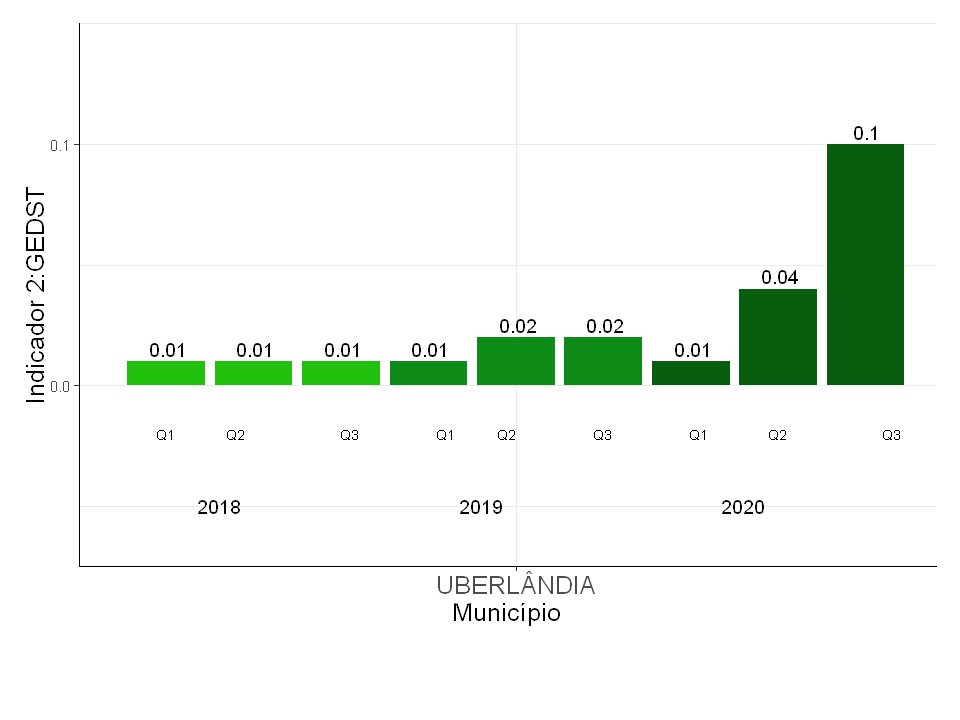

In [44]:
Dados_plot_mun  <-  Dados_Mun %>% filter(indicador==INDICADORES[INDICADOR], ibge==municipio_selecionado)

n_estados = length(unique(Dados_plot_mun$uf))

sequencia <- rep(c(0.6,0.68,0.81,0.92,0.99,1.1,1.21,1.30,1.43),n_estados)+
  rep(c(0:(n_estados-1)),each=9)
sequencia2 <- rep(seq(0.66,1.4,0.3),n_estados)+
  rep(c(0:(n_estados-1)),each=3)

fig(8,6)
Dados_plot_mun <- Dados_plot_mun %>% arrange(uf,desc(tempo))

Dados_plot_mun  %>% ggplot(aes(x=nome_mun,y=indicador_calculado,fill=tempo))+
  geom_col(position=position_dodge(width=0.9),width=0.8)+
  
  geom_text(label=Dados_plot_mun$indicador_calculado,
            position = position_dodge(width=0.9),
            size=4, hjust = +0.45, vjust=-.35)+
  labs(y= paste0("Indicador ", INDICADORES[INDICADOR]), x='Município')+
  
  scale_fill_manual(values=rep(c('#20c00c','#0e8b16','#095d0e'),each=3))+
  
  annotate(geom = "text", x =sequencia , y = -.02, label = rep(Quadrimestres,
                                                               3*n_estados), size = 3) +
  
  annotate(geom = "text", x = sequencia2 , y = -.05, label = rep(Anos,
                                                                 n_estados), size = 4) +
  
  coord_cartesian(ylim = c(-.075, max(Dados_plot_mun$indicador_calculado)+ .05), expand = FALSE, clip = "off",
                  xlim=c(0.5,max(sequencia)+0.05))+
  scale_y_continuous(breaks = seq(0,max(Dados_plot_mun$indicador_calculado),0.1))+
  theme_bw()+
  theme(plot.margin = unit(c(1, 1, 4, 1), "lines"),
        panel.border = element_blank(),
        axis.line.x = element_line(colour='black'),
        axis.line.y = element_line(colour='black'),
        axis.text.x = element_text(size=15),
        axis.title = element_text(size=15),
        legend.text = element_text(size=6),
        legend.key.size = unit(0.5, 'cm'),
        legend.title = element_text(size=7),
        legend.position = "none")


## Mapa da Região de Saúde do Município Selecionado

In [55]:
states <- states_completo
states$ibge <- as.numeric(str_sub(states$code_mn,1,6))

In [56]:
options(warn=-1)

no_axis <- theme(axis.title=element_blank(),
axis.text=element_blank(),
axis.ticks=element_blank())

nome_mun_selecionado <- Dados_Mun$nome_mun[Dados_Mun$ibge==municipio_selecionado] %>% unique()
uf_selecionada <- Dados_Mun$uf[Dados_Mun$ibge==municipio_selecionado] %>% unique()

reg_saude_sel <- Dados_Mun$cod_reg_saude[Dados_Mun$ibge==municipio_selecionado] %>% unique()

In [57]:
tempo_inicial <- str_c(as.character(ANO_INICIAL),Quadrimestres[Quadrimestre_Inicial])

tempo_final <- str_c(as.character(ANO_FINAL),Quadrimestres[Quadrimestre_Final])

Dados_mapa <- Dados_Mun %>% filter(tempo%in%c(tempo_inicial,tempo_final), indicador==INDICADORES[INDICADOR], uf==uf_selecionada) %>% 
  select(reg_saude, cod_reg_saude,indicador_calculado, ibge, uf, nome_mun,tempo, indicador)


In [58]:
states <- states %>% filter(abbrv_s==uf_selecionada)

In [59]:
states <- left_join(states, Dados_mapa)

Joining, by = "ibge"


In [60]:
nc3_points <- st_point_on_surface(states)

nc3_points <- nc3_points %>% filter(cod_reg_saude == reg_saude_sel)

nc3_coords <- as.data.frame(st_coordinates(nc3_points))

nc3_coords$NAME <- states$name_mn[states$cod_reg_saude==reg_saude_sel]

states <- states %>% filter(cod_reg_saude == reg_saude_sel)

## Mapa do indicador selecionado para os municípios pertencentes a região de saúde.

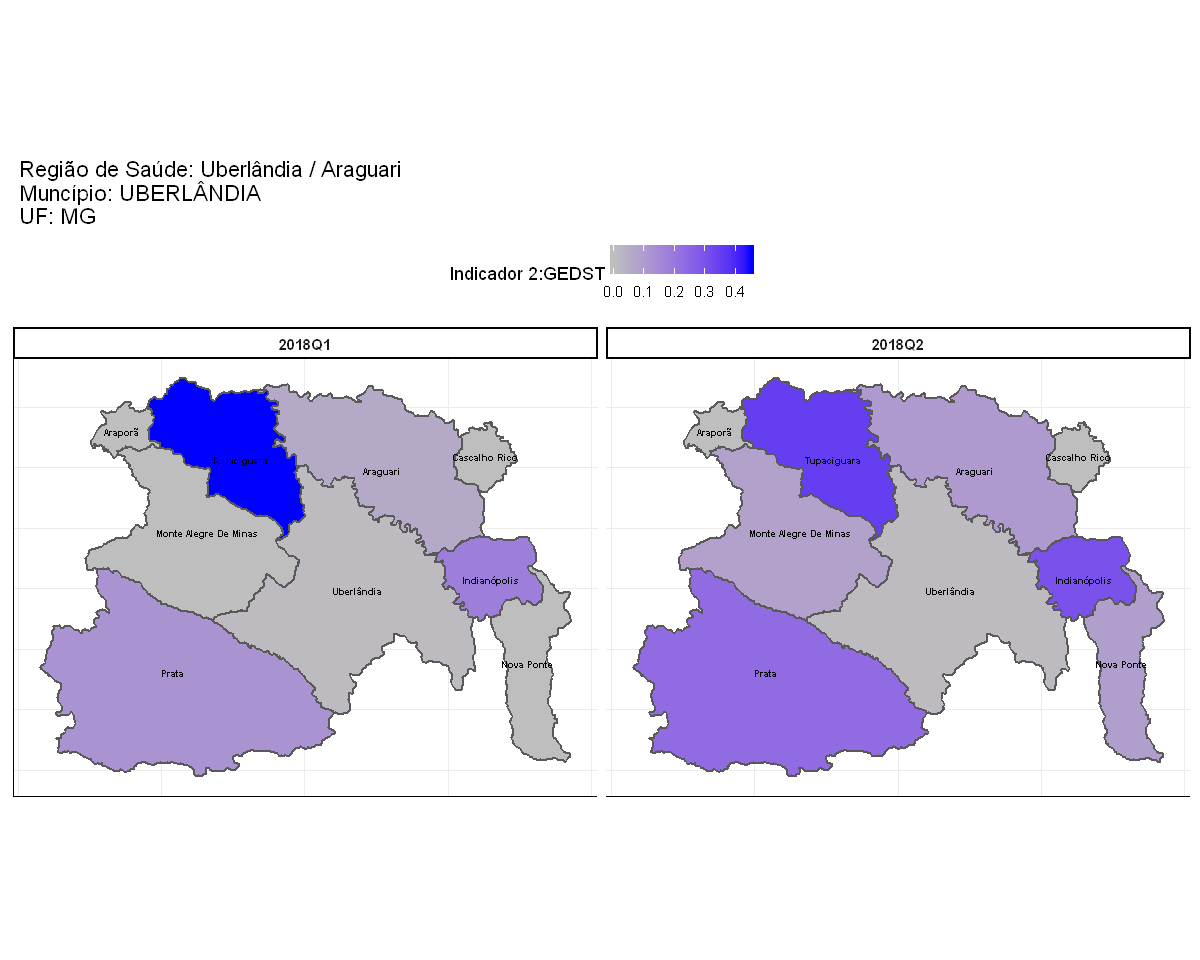

In [61]:
fig(10,8)
ggplot() +
geom_sf(data=states, aes(fill =indicador_calculado), size = 0.7, show.legend = TRUE) +
theme_minimal()+
ggtitle(paste0(" Região de Saúde: ",states$reg_saude[states$cod_reg_saude==reg_saude_sel][1],
              '\n Muncípio: ',nome_mun_selecionado ,' \n UF: ',uf_selecionada))+

scale_fill_gradient(high = "blue", low= "gray", na.value = "black",
                     name=paste("Indicador",INDICADORES[INDICADOR] ))+
theme(legend.position="top")+
geom_text(data = nc3_coords, aes(X, Y, label = NAME), colour = "black",fontface = "bold", size=2)+
facet_grid(cols=vars(tempo))+
theme(axis.title.y=element_text(colour="black",size=12),
                  axis.title.x=element_text(colour="black",size=12),
                  axis.text=element_text(colour="black",size=9.5),
                  panel.border=element_blank(),
                  axis.line=element_line(colour="black"))+
theme(strip.text = element_text(face="bold", size=9,lineheight=5.0),
strip.background = element_rect(fill="white", colour="black",
size=1))+
no_axis

## Tabela do indicador selecionado para os municípios pertencentes a região de saúde.

In [ ]:
datatable(unique(Dados_mapa[,c('ibge','uf','nome_mun','tempo','indicador_calculado')]),colnames=c('Código IBGE','UF','Município','Ano/Quadrimestre','Indicador'), options = list(lengthMenu = c(5, 10,15), pageLength = 5, names))

# Boxplot por Região de Saúde

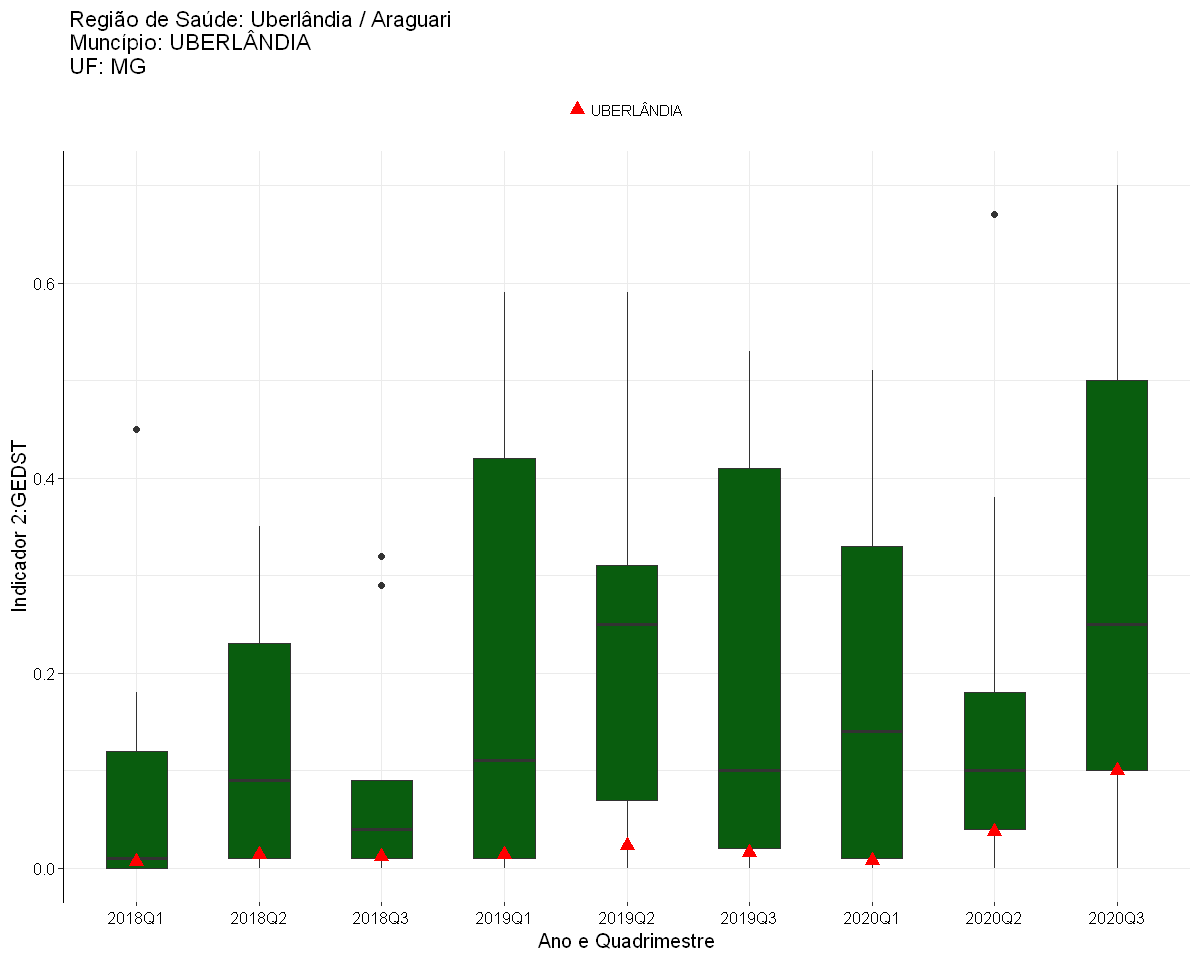

In [62]:
reg_saude_sel <- Dados_Mun$cod_reg_saude[Dados_Mun$ibge==municipio_selecionado] %>% unique()

name_reg_saude_sel <- Dados_Mun$reg_saude[Dados_Mun$ibge==municipio_selecionado] %>% unique()

uf_selecionada <- Dados_Mun$uf[Dados_Mun$ibge==municipio_selecionado] %>% unique()

reg_saude_sel <- Dados_Mun$cod_reg_saude[Dados_Mun$ibge==municipio_selecionado] %>% unique()

nome_reg_saude <- Dados_Mun$reg_saude[Dados_Mun$ibge==municipio_selecionado] %>% unique()

Dados_boxplot <- Dados_Mun %>% filter(cod_reg_saude==reg_saude_sel, indicador==INDICADORES[INDICADOR])



ggplot(Dados_boxplot, aes(x=tempo, y=indicador_calculado)) + 
geom_boxplot(fill=c('#095d0e'),width=0.5)+
  geom_jitter(data=Dados_boxplot %>% filter(ibge==municipio_selecionado),
              shape=17,size=3,
              aes(x=tempo, y=indicador_calculado, colour=nome_mun),
              position=position_jitter(0),
              show.legend = TRUE)+
scale_color_manual(values = "red")+

ggtitle(paste0(" Região de Saúde: ",name_reg_saude_sel ,
              '\n Muncípio: ',nome_mun_selecionado ,' \n UF: ',uf_selecionada))+
  labs(x="Ano e Quadrimestre",y= paste0('Indicador ', INDICADORES[INDICADOR]))+

  theme_bw()+
  
  
theme(axis.title.y=element_text(colour='black',size=12),
        axis.title.x=element_text(colour='black',size=12),
        axis.text=element_text(colour='black',size=9.5),
        panel.border=element_blank(),
        axis.line.y=element_line(colour='black'),
        legend.title=element_blank(),
       legend.position='top')


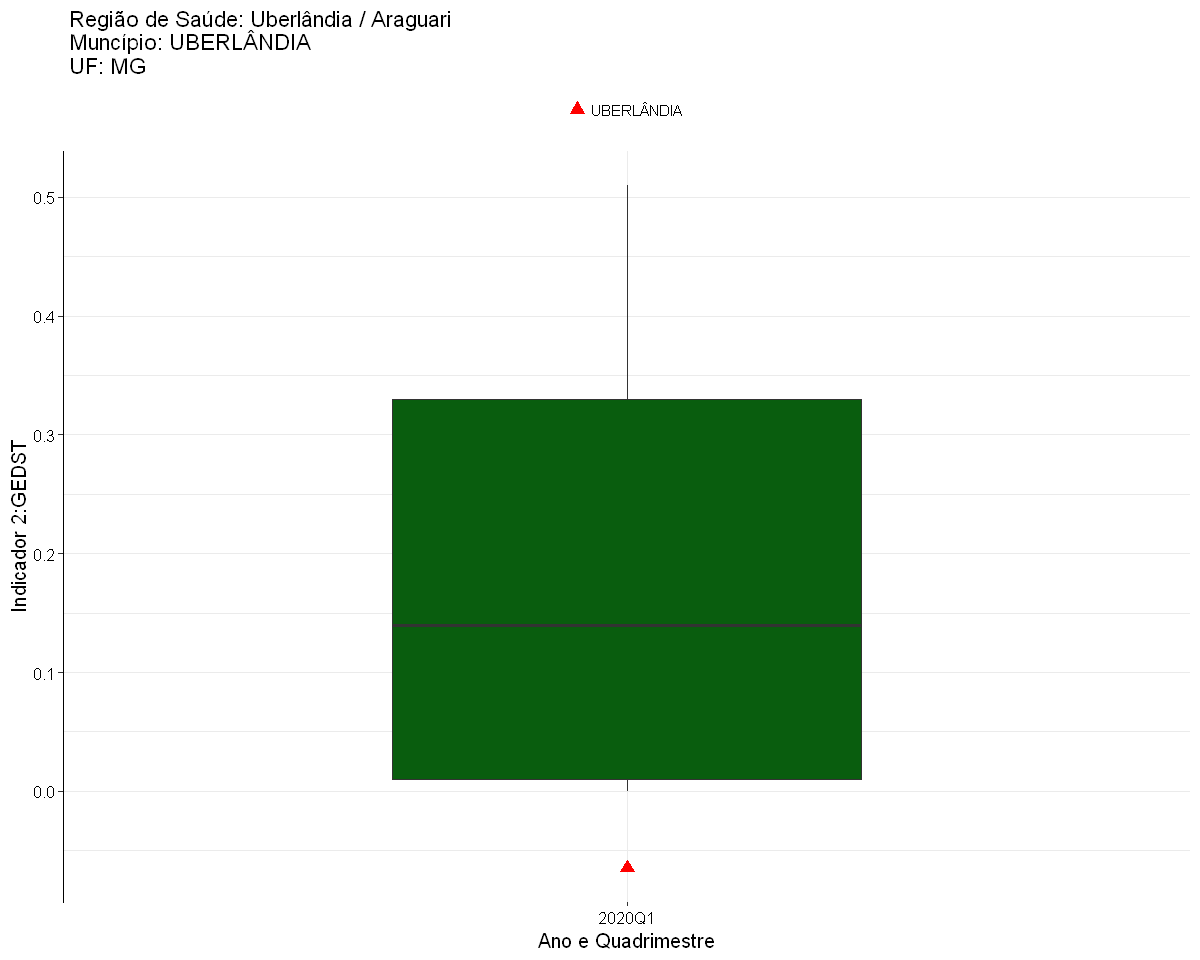

In [63]:
dados_box_2 <- Dados_Mun %>% filter(cod_reg_saude==reg_saude_sel, indicador==INDICADORES[INDICADOR],tempo=='2020Q1')
dados_jitter <- dados_box_2 %>% filter(ibge==municipio_selecionado)

ggplot(dados_box_2, aes(x=tempo, y=indicador_calculado)) + 
geom_boxplot(fill=c('#095d0e'),width=0.5)+
  geom_jitter(data=dados_jitter,
              shape=17,size=3,
              aes(x=tempo, y=indicador_calculado, colour=nome_mun),
              position=position_jitter(0),
              show.legend = TRUE)+
scale_color_manual(values = "red")+

ggtitle(paste0(" Região de Saúde: ",name_reg_saude_sel ,
               '\n Muncípio: ',nome_mun_selecionado ,' \n UF: ',uf_selecionada))+

  labs(x="Ano e Quadrimestre",y= paste0('Indicador ', INDICADORES[INDICADOR]))+

  theme_bw()+
  theme(axis.title.y=element_text(colour='black',size=12),
        axis.title.x=element_text(colour='black',size=12),
        axis.text=element_text(colour='black',size=9.5),
        panel.border=element_blank(),
        axis.line.y=element_line(colour='black'),
        legend.title=element_blank(),
       legend.position='top')



# Boxplot por Estado

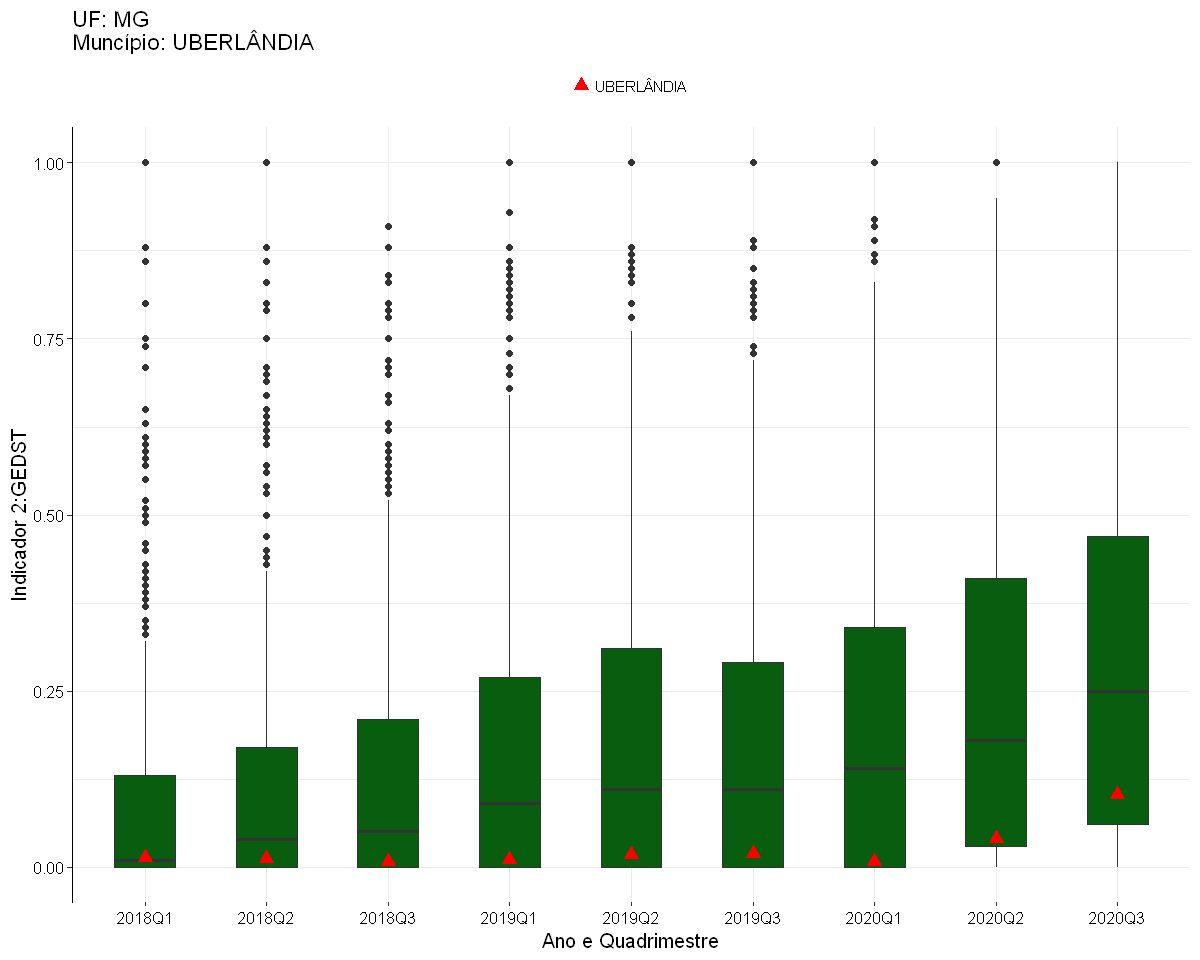

In [64]:
UF_selecionada <- Dados_Mun$uf[Dados_Mun$ibge==municipio_selecionado] %>% unique()

Dados_boxplot <- Dados_Mun %>% filter(uf==UF_selecionada,indicador==INDICADORES[INDICADOR])


ggplot(Dados_boxplot, aes(x=tempo, y=indicador_calculado)) + 
geom_boxplot(fill=c('#095d0e'),width=0.5)+
  geom_jitter(data=Dados_boxplot %>% filter(ibge==municipio_selecionado),
              shape=17,size=3,
              aes(x=tempo, y=indicador_calculado, colour=nome_mun),
              position=position_jitter(0),
              show.legend = TRUE)+
scale_color_manual(values = "red")+

ggtitle(paste0('UF: ',uf_selecionada, '\nMuncípio: ',nome_mun_selecionado ))+
  labs(x="Ano e Quadrimestre",y= paste0('Indicador ', INDICADORES[INDICADOR]))+

  theme_bw()+
  
  theme(axis.title.y=element_text(colour='black',size=12),
        axis.title.x=element_text(colour='black',size=12),
        axis.text=element_text(colour='black',size=9.5),
        panel.border=element_blank(),
        axis.line.y=element_line(colour='black'),
        legend.title=element_blank(),
       legend.position='top')